# Вспомогательные функции

In [1]:
import shutil
import os
# Helper method to run Tensorboard in Colab
def reinit_tensorboard(clear_log = True):
  logs_base_dir = "/content/runs" # Directory for log files
  if clear_log:    
    shutil.rmtree(logs_base_dir, ignore_errors = True)
    os.makedirs(logs_base_dir, exist_ok=True)
  # Colab magic
  %reload_ext tensorboard
  %tensorboard --logdir {logs_base_dir}

In [2]:
import torch
import random
import numpy as np
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Задание 1. Onera Satellite Change Detection Dataset

В этом задании мы будем работать с датасетом `OSCD images` - [Onera Satellite Change Detection Dataset](https://rcdaudt.github.io/oscd/). 

В наборе данных рассматривается вопрос обнаружения изменений между спутниковыми снимками разных дат.

Он включает 24 пары изображений, полученных со спутников Sentinel-2 в период с 2015 по 2018 год. Места съемки выбраны по всему миру, в Бразилии, США, Европе, на Ближнем Востоке и в Азии. Для каждого места представлены зарегистрированные пары спутниковых изображений, полученных спутниками Sentinel-2. Пространственное разрешение снимков варьируется в пределах 10 м, 20 м и 60 м.

Для всех 14 пар учебных и 10 пар тестовых снимков предоставлены данные об изменениях на уровне пикселей. Аннотированные изменения сосредоточены на городских изменениях, таких как новые здания или новые дороги.

Вот их то мы и будем искать

## Загрузка и подготовка данных

In [ ]:
import os

path = '/content/oscd/'
dataset_path = '/content/oscd_images/'

!mkdir -p {path}
!gdown --id 1jidN0DKEIybOrP0j7Bos8bGDDq3Varj3
!unzip OSCD.zip -d {path}
!rm OSCD.zip
!mv {path}'/Onera Satellite Change Detection dataset - Images.zip' {path}/Images.zip
!mv {path}'/Onera Satellite Change Detection dataset - Train Labels.zip' {path}/TrainLabels.zip
!mv {path}'/Onera Satellite Change Detection dataset - Test Labels.zip' {path}/TestLabels.zip
!unzip {path}/Images.zip -d {path}
!unzip {path}/TrainLabels.zip -d {path}
!unzip {path}/TestLabels.zip -d {path}
!mv {path}'/Onera Satellite Change Detection dataset - Images' {path}/images
!mv {path}'/Onera Satellite Change Detection dataset - Train Labels' {path}/train_labels
!mv {path}'/Onera Satellite Change Detection dataset - Test Labels' {path}/test_labels
!rm {path}/Images.zip
!rm {path}/TrainLabels.zip
!rm {path}/TestLabels.zip

!mkdir {dataset_path}

!mkdir {dataset_path}/train
!mkdir {dataset_path}/test

path_final = '/content/oscd/images/'
for folder in os.listdir(path_final):
    if os.path.isdir(path_final+folder):
        for im in os.listdir(path_final+folder+'/'+'pair'):
            if folder in os.listdir('/content/oscd/train_labels/'):
                dest = 'train/'
                if 'cm.png' in os.listdir('/content/oscd/train_labels/'+folder+'/cm/'):
                    os.rename('/content/oscd/train_labels/'+folder+'/cm/cm.png', dataset_path+dest+folder+'_mask.png')
            else:
                dest = 'test/'
                if 'cm.png' in os.listdir('/content/oscd/test_labels/'+folder+'/cm/'):
                    os.rename('/content/oscd/test_labels/'+folder+'/cm/cm.png', dataset_path+dest+folder+'_mask.png')
            os.rename(path_final+folder+'/'+'pair/'+im, dataset_path+dest+folder+'_'+im)

### Посмотрим что мы вообще загрузили

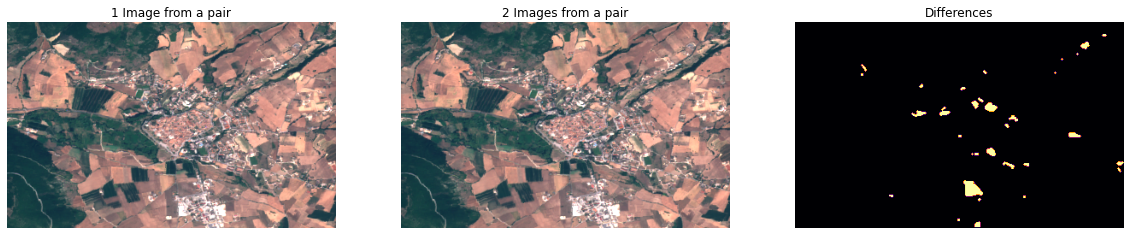

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

city = 'norcia'
img1 = Image.open('/content/oscd_images/test/%s_img1.png' % city) 
img2 = Image.open('/content/oscd_images/test/%s_img2.png' % city)
mask = Image.open('/content/oscd_images/test/%s_mask.png' % city)

fig,ax = plt.subplots(ncols=3, figsize=(20,7))
ax[0].imshow(img1)
ax[1].imshow(img1)
ax[2].imshow(mask, cmap='inferno')

ax[0].set_title('1 Image from a pair')
ax[1].set_title('2 Images from a pair')
ax[2].set_title('Differences')

for a in ax:
    a.axis('off')

### Разобьем наши данные на патчи

Как мы видим данных не очень много - всего 24 пары. При этом они довольно большого разрешения. Перед нами стоит задача определять изменения между парами. Нужно ли нам для этого смотреть на все изображение сразу? Нет. Поэтому мы разобьем их на патчи.

#### Задача 1.1. Разбейте спутниковые снимки на патчи
 Разбейте спутниковые снимки на патчи размером (15,15). Поместите все патчи `img1` в папку 1, `img2` в папку 2, `mask` в папку mask. Не забудьте про заранее заданное разбиение на train и test

In [5]:
!mkdir /content/oscd_patches
!mkdir /content/oscd_patches/train
!mkdir /content/oscd_patches/train/1/
!mkdir /content/oscd_patches/train/2/
!mkdir /content/oscd_patches/train/mask/
!mkdir /content/oscd_patches/test
!mkdir /content/oscd_patches/test/1/
!mkdir /content/oscd_patches/test/2/
!mkdir /content/oscd_patches/test/mask/

In [6]:
from tqdm.notebook import tqdm
from glob import glob
from PIL import Image
import numpy as np

def produce_patches(root_dir, desination_dir, partition, patch_size=15):
    img1_path = sorted(glob('%s/%s/*img1*' % (root_dir, partition)))
    img2_path = sorted(glob('%s/%s/*img2*' % (root_dir, partition)))
    mask_path = sorted(glob('%s/%s/*mask*' % (root_dir, partition)))
    

    for idx in tqdm(range(len(img1_path))):
        img1 = Image.open(img1_path[idx])
        img2 = Image.open(img2_path[idx])
        mask = Image.open(mask_path[idx])

        # Resize image so each size is divisable by patch size
        # in task 4.2 has hints
        
        ## ENTER YOUR CODE HERE ##

        # split image to patches of size=(patch_size,patch_size)
        def crop(img, crop_path, height=15, width=15, k=0):
          list=[]
          imgwidth, imgheight = img.size
          for i in range(0,imgheight,height):
            for j in range(0,imgwidth,width):
              crop = (j, i, j+width, i+height)
              patch = img.crop(crop)
              list.append(patch)
          return list
        
        img1_patches=crop(img1, 'oscd_images/'+partition+'/1')
        img2_patches=crop(img2, 'oscd_images/'+partition+'/2')
        mask_patches=crop(mask, 'oscd_images/'+partition+'/mask')

        for i in range(len(img1_patches)):
        
            name_1 = '%s%s/1/%s_%i.png' % (desination_dir, partition, img1_path[idx].split('/')[-1].split('_')[0], i)
            name_2 = '%s%s/2/%s_%i.png' % (desination_dir, partition, img2_path[idx].split('/')[-1].split('_')[0], i)
            name_mask = '%s%s/mask/%s_%i.png' % (desination_dir, partition, mask_path[idx].split('/')[-1].split('_')[0], i)
            img1_patches[i].save(name_1)
            img2_patches[i].save(name_2)
            mask_patches[i].save(name_mask)

dataset_path = '/content/oscd_images/'
desination_dir = '/content/oscd_patches/'

produce_patches(dataset_path, desination_dir, partition='train')

  0%|          | 0/14 [00:00<?, ?it/s]

In [7]:
produce_patches(dataset_path, desination_dir, partition='test')

  0%|          | 0/10 [00:00<?, ?it/s]

### Соберем `Dataset`

In [8]:
from torch.utils.data import Dataset
from torchvision.transforms import Compose, ToTensor, RandomAutocontrast, RandomAdjustSharpness
from PIL import Image
import torchvision

class SatDataset(Dataset):
    def __init__(self, root_dir, partition, size=15, thres=0.5, transform=None):
        self.thres = thres
        self.root_dir = root_dir
        self.transform = transform
        self.partition = partition

        self.img1_path = os.listdir('%s/%s/1/' % (self.root_dir, partition))
        self.img2_path = os.listdir('%s/%s/2/' % (self.root_dir, partition))
        self.mask_path = os.listdir('%s/%s/mask/' % (self.root_dir, partition))

    def __len__(self):
        return len(self.img1_path)

    def __getitem__(self, idx):
        
        img1 = Image.open('%s/%s/1/%s' % (self.root_dir, self.partition, self.img1_path[idx]))
        img2 = Image.open('%s/%s/2/%s' % (self.root_dir, self.partition, self.img2_path[idx]))
        mask = np.array(Image.open('%s/%s/mask/%s' % (self.root_dir, self.partition, self.mask_path[idx])))
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if np.mean(mask/mask.max()) < self.thres:
            label = torch.tensor(0)
        else:
            label = torch.tensor(1)

        return torch.stack((img1, img2)), label

### Задача 1.2. Определим аугментации для данных

Подумайте, какие аугментации будут способстовать обнаружению изменений. Внимательно посмотрите на пары изображений. Какие аугментации будут бессмысленны? Какие только навредят?

Используйте любые библиотеки аугментации из лекции (augly, torchvision, albumentation и так далее) на свой вкус

In [9]:
from torchvision.transforms import RandomPerspective, RandomRotation, RandomAffine, RandomHorizontalFlip
transform = Compose([RandomPerspective(distortion_scale=0.5, p=0.5),
                     RandomRotation(degrees=(0, 180)),
                     RandomHorizontalFlip(p=0.5),
                     ToTensor()])


transform1 = Compose([ToTensor()])
from torch.utils.data import DataLoader
torch.manual_seed(2)


Sat_dataloader_original = DataLoader(
    SatDataset('/content/oscd_patches/',partition='train', transform=transform1), batch_size=8, shuffle=False)

Sat_dataloader = DataLoader(
    SatDataset('/content/oscd_patches/',partition='train', transform=transform), batch_size=8, shuffle=False)

data_original=iter(Sat_dataloader_original)
data = iter(Sat_dataloader)

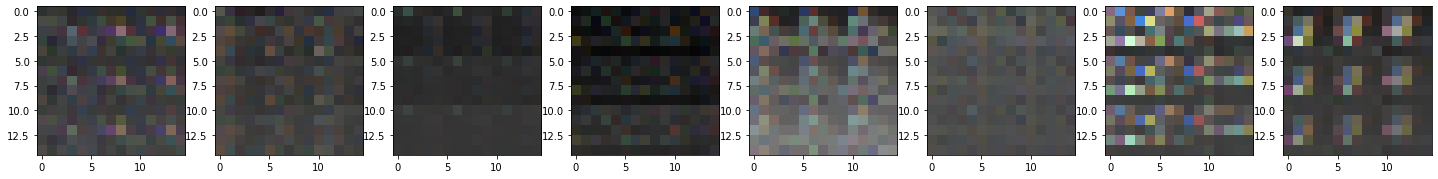

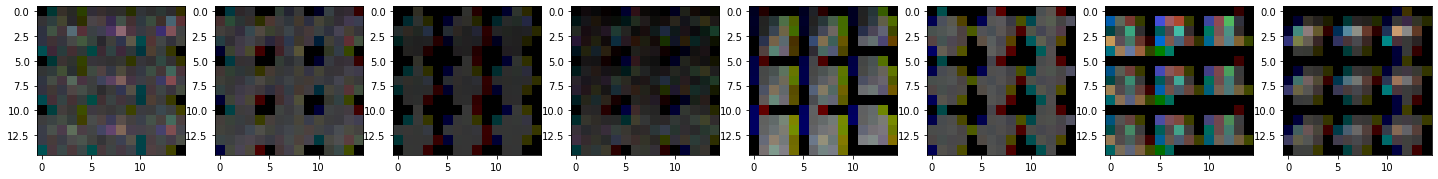

In [10]:
def show_img(img):
  fig, ax = plt.subplots(1,8,figsize=(25, 25))
  img_np = img[0].numpy()
  for i in range(len(img_np)):
    img_np_=img_np[i][0].reshape(15,15,3)
    ax[i].imshow(img_np_)
  plt.show()

data_original=iter(Sat_dataloader_original)
data = iter(Sat_dataloader)

show_img(data_original.next())
show_img(data.next())

### Разобьем наш train dataset на train и val 

In [11]:
desination_dir = '/content/oscd_patches/'

dataset = SatDataset(desination_dir, partition='train', transform = transform)

train_set, val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), int(len(dataset)) - int(len(dataset)*0.8)])

## Сиамские сети

В лекции мы разобрали, что когда данных немного и нужно определить похожи изображения или нет - можно использовать сиамские сети. Для задачи определения изменений на спутниковых снимках нам как раз подходит.

### Задача 2. Напишите Сиамскую сеть для определния изменений в парах изображений

In [12]:
import torch
import torch.nn as nn

class Siam(nn.Module):
    def __init__(self, channels: int = 3, t: int = 2, num_classes: int = 2):
        super().__init__()
        ## ENTER YOUR CODE HERE ##

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ## ENTER YOUR CODE HERE ##
        return x

class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet18(pretrained = False)
        # Because we use grayscale images reduce input channel count to one
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        # Replace ImageNet 1000 class classifier with 64- out linear layer 
        self.model.fc = nn.Linear(self.model.fc.in_features, 64)

    def forward(self, anchor, positive, negative):
        output1 = self.model(anchor)
        output2 = self.model(positive)
        output3 = self.model(negative)
        
        return output1, output2, output3

### Посмотрим на распределение классов в датасете

Логично ожидать, что изменений (в масштабах всего спутникового снимка) будет нне так уж и много.

#### Задача 2.1. Посмотрите на распределение классов внутри датасета. Визуализируйте полученные данные

In [97]:
## ENTER YOUR CODE HERE ##
#for i in range(8):
train_features, train_labels = next(iter(train_set))
sum=0
for i in range(len(train_set)):
  sum+=train_set[i][1].item()
sum

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


1230

#### Задача 2.2. Используйте любой из подходящих методов, которые обсуждались в лекции, для того что бы компенсировать несбалансированность данных в датасете

In [ ]:
## ENTER YOUR CODE HERE ##

### Обучение

Когда мы обучаем нейронные сети, нам важно наблюдать два показателя - loss и какую-то метрику, которая показывает насколько хорошо наша модеель справляется с поставленной задачей. Обычно мы используем `accuracy`, но как уже упомяналось в лекции, в случае несбалансированных классов - это бессмысленно.

#### Задача 3. Разберитесь с метрикой *Matthews correlation coefficient (MCC)* и реализуйте ее расчет в функции `validate`

In [ ]:
def compute_TrueFalse(preds, ground_truth, thres=0.5):
    ## ENTER YOUR CODE HERE ##
    return tps, tns, fps, fns

def compute_MCC(tps, tns, fps, fns):
    ## ENTER YOUR CODE HERE ##
    return matthews_corr_coef

In [ ]:
def validate(model,valloader,device):
    model.eval()
    mcc = []
    ## ENTER YOUR CODE HERE ##
    return np.mean(mcc)

### Функция `train`

Эту функцию можно оставить без изменений (хотя если вы считаете что в ней можно что-то улучшить - улучшите)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

def train(model, trainset, valset, batch_size, n_epoch, lr, device, comment = ""):
  writer = SummaryWriter(comment)
  step = 0

  # Run model on cuda
  print('Using device:', device)
  model.to(device)
  
  train_loader = DataLoader(trainset, batch_size = batch_size, shuffle = False, sampler=sampler_train)
  val_loader = DataLoader(valset, batch_size = batch_size, shuffle = False)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

  for epoch in range(n_epoch):
    for img_batch, labels_batch in train_loader:

      model.train()
      optimizer.zero_grad()
      output = model(img_batch.to(device).float())
      loss = criterion(output, labels_batch.to(device))
      loss.backward()
      optimizer.step()
      if step % 100 == 0:
        writer.add_scalar('Loss/train',loss.cpu().item(),step)
        writer.flush()
      step += 1

    accuracy = validate(model,val_loader,device)

    writer.add_scalar('MCC',accuracy,epoch)
    print("Epoch {} Loss {:.2f} MCC {:.2f}".format(epoch,loss.item(),accuracy))
    writer.flush()
  writer.close()

#### Задача 4. Оптимизируйте гиперпараметры сети с помощью Optuna.

В лекции мы оптимизировали `lr`. Возможно в вашей имплементации есть еще какие-то параметры которые можно оптимизировать. Например количество слоев, kernel size или аугментации.


In [ ]:
!pip install optuna

In [ ]:
import optuna

# 1. Define an objective function to be maximized.
def objective(trial):

    ## ENTER YOUR CODE HERE ##



In [ ]:
# 3. Create a study object and optimize the objective function.

desination_dir = '/content/oscd_patches/'
dataset = SatDataset(desination_dir, partition='train', transform = transform)
    
study = optuna.create_study('ВАШ КОД')
study.optimize(objective, n_trials=100)

In [ ]:
study.best_params

#### Задача 4.1. Обучите Сиамскую сеть.

Используйте tensorboard для отображения результатов

In [ ]:
reinit_tensorboard(clear_log = False)

In [ ]:
model = Siam()

batch_size = ## ENTER YOUR CODE HERE ##
n_epoch = ### ENTER YOUR CODE HERE ##
lr = ## ENTER YOUR CODE HERE ##
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(model, train_set, val_set, batch_size, n_epoch, lr, device)

### Проверка

#### Задача 4.2 Проверьте насколько хорошо ваша сеть справляется на тестовом датасете.

Используйте предоставленый код, внеся изменения там где они необходимы. 

In [ ]:
"""
0. Import libraries
1. Download random image of random size from the internet with PIL and requests
2. Resize image so each size is divisable by patch size
3. split image to patches of size=(15,15)
4. stack tiles into a numpy array
5. create `img_new` and assemble tiles back to the original image seemlessly
6. Resize back to original image size
7. display the image
"""

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def img_to_patches(img):
    w = img.size[0]
    h = img.size[1]

    # Resize image so each size is divisable by patch size

    ## ENTER YOUR CODE HERE ##

    # split image to patches of size=(15,15)

    ## ENTER YOUR CODE HERE ##

    # stack tiles into a numpy array

    ## ENTER YOUR CODE HERE ##
    return ## ENTER YOUR CODE HERE ##

city = 'norcia'
img1 = Image.open('/content/oscd_images/test/%s_img1.png' % city) 
img2 = Image.open('/content/oscd_images/test/%s_img2.png' % city)
mask = Image.open('/content/oscd_images/test/%s_mask.png' % city)

## ENTER YOUR CODE HERE ##

# create `img_new` and assemble tiles back to the original image seemlessly

def patches_to_img('ВАШ КОД'):
    if mask:
        img_new = np.zeros((h,w))
    else:
        img_new = np.zeros((h,w,3))

    ## ENTER YOUR CODE HERE ##

    # Resize back to original image size

    ## ENTER YOUR CODE HERE ##
    return img_new

model.to('cpu')
model.eval()

# ВАШ КОД

# display the image

fig,ax = plt.subplots(ncols=4, figsize=(20,10))
ax[0].imshow(img_new1)
ax[1].imshow(img_new2)
ax[2].imshow(img_new1)
ax[3].imshow(img_new2)
ax[2].imshow(mask_new, cmap='inferno', alpha=0.5)
ax[3].imshow(pred_mask, cmap='inferno', alpha=0.5)

for a in ax:
    a.axis('off')

### Задача 5. Реализуйте тот или иной метод ансамблинга предсказаний модели.

Например можно сдвгать картинку на 1 пиксель, делать предсказание, и сдвигать снова. А результаты сложить. Получится что модель как бы голосует за каждый пиксель по отдельности

In [ ]:
## ENTER YOUR CODE HERE ##